# **2023 NFL Big Data Bowl**
### Sol Ben-Ishay

## **ML Models**

### **General**

In [1]:
%run feature_engineering.ipynb

#### **Import ML Libraries**

In [2]:
# Import ML Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from IPython.display import display
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn import tree
from sklearn import neighbors

#### **ML Utilities**

In [3]:
# Function to train/test/evaluate a single classification model
def run_experiment(model, X_train, y_train, X_test, y_test, show_dt):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    if show_dt:
        tree.plot_tree(model)

    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

In [4]:
# Function to train/test/evaluate multiple classification models
def run_experiments(models, X_train, y_train, X_test, y_test):
    with plt.ioff():
        # Create the performance results dictionary and main plot
        results = {"Model Name":[],"Precision":[],"Recall":[],"F1":[],"Accuracy":[]}
        confusion_matrices, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
        confusion_matrices.suptitle("Model Confusion Matrices")
        confusion_matrices.tight_layout()

        for model_name, ax in zip(list(models.keys()), axs.ravel()):
            # Train/test the model
            model = models[model_name]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Create a confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=ax)
            ax.title.set_text(model_name)

            # Append the performance results
            results['Model Name'].append(model_name)
            results['Precision'].append(precision_score(y_test, y_pred))
            results['Recall'].append(recall_score(y_test, y_pred))
            results['F1'].append(f1_score(y_test, y_pred))
            results['Accuracy'].append(accuracy_score(y_test, y_pred))

        # Show the performance metrics and plot the confusion matrices
        print("Experiment Results:")
        results_df = pd.DataFrame(results).style.set_caption("Model Performance Metrics")
        display(results_df)
        print()
        plt.show()

### **Model A. Predict whether a DL will get double teamed on a play (pre-snap)**

### **Model B. Predict whether a DL will get a pressure on a play (pre-snap)**

### **Model C. Predict whether a DL will get a pressure on a play (intra-play)**

#### **Feature Engineering**

In [5]:
## Get the relevant data for the model(s)
# Note: Only training/testing on players who pass rushed more than 35 snaps and for plays their role was "Pass Rush"
# Note: potentially consider OLB in DL
# Get the high snap pass rushers
high_snap_pass_rushers = player_level_df.query("officialPosition in ['NT','DT','DE'] and pff_role == 'Pass Rush'").nflId.value_counts().loc[lambda c: c > 35].index.tolist()

# Get all the relevant model data (Don't include game/play/player info)
player_level_coi = ['gameId', 'playId', 'nflId', 'displayName',
        'officialPosition', 'pff_role', 'pff_positionLinedUp', 'pff_pressure',
        # 'pff_hit', 'pff_hurry', 'pff_sack'
        ]
play_level_coi = ['gameId','playId','passResult','defendersInBox', 'down', 'yardsToGo']
tracking_coi = ['gameId','playId','nflId','speed_at_1.5','depth_at_1.5','distance_at_1.5']
model_c_df = (player_level_df[player_level_coi].query(f"nflId in {high_snap_pass_rushers} and pff_role == 'Pass Rush'")
        .merge(play_level_df[play_level_coi], how='left', on=['gameId','playId'])
        .merge(dl_alignment_df, how='left', on=['gameId','playId','nflId'])
        .merge(dl_num_blockers_df, how='left', on=['gameId','playId','nflId'])
        # .merge(time_to_depth_df, how='left', on=['gameId','playId','nflId'])
        .merge(pass_rushers_at_key_df[tracking_coi], how='left', on=['gameId','playId','nflId'])
        # .merge(pass_rushers_at_key2_df, how='left', on=['gameId','playId','nflId'])
        # .merge(rusher_dist_at_rel_df, how='left', on=['gameId','playId','nflId'])
        .merge(snap_to_action_df, how='left', on=['gameId','playId'])
        .drop(columns=['gameId', 'playId', 'nflId', 'displayName','pff_role']))

## Clean up NAs
# A missing snap_to_action_time/distance at rel occurs when a certain play is missing either a snap or action event
# Investigate missing dl_alignment/distance at 1.5
model_c_df = model_c_df.dropna(subset=['dl_alignment','distance_at_1.5','defendersInBox'], how='any')
# numBlockers and multBlockers is N/A when a player is unblocked
model_c_df = model_c_df.fillna(value={'numBlockers':0,'multBlockers':'U'})

## Filter plays
# Only look at plays that were either C, I, S, or IN (no scrambles, laterals, etc)
model_c_df = model_c_df.query("passResult in ['C','I','S','IN','R']").drop(columns=["passResult"])
#  Only look at plays that have a snap to action time within the 95th percentile
model_c_df = (model_c_df[model_c_df.snap_to_action_time < model_c_df.snap_to_action_time.quantile(.95)]
        .drop(columns=["snap_to_action_time"]))

model_c_df.head()

,officialPosition,pff_positionLinedUp,pff_pressure,defendersInBox,down,yardsToGo,dl_alignment,numBlockers,multBlockers,speed_at_1.5,depth_at_1.5,distance_at_1.5
0,DE,ROLB,1.0,6.0,3.0,2.0,edge,1.0,N,5.21,4.94,6.073986
1,DE,DRT,0.0,6.0,3.0,2.0,gap,2.0,Y,1.89,2.55,5.720813
2,DT,RE,1.0,6.0,3.0,2.0,head_up,0.0,U,2.77,1.88,6.234645
3,DE,DRT,0.0,6.0,1.0,10.0,gap,2.0,Y,2.75,2.79,4.446268
4,DE,ROLB,0.0,6.0,1.0,10.0,edge,1.0,N,3.62,2.24,5.298726


In [6]:
# Check for NAs
# A missing time_to_depth occurs when the rusher did not make it to 3 yards
# Missing metrics at 2 seconds indicate plays that did not last 2 seconds (maybe should filter out?)
if sum(model_c_df.isna().sum().values) != 0:
    print(model_c_df.isna().sum().loc[lambda x: x > 0])

In [7]:
# Encode the categorical data

# Official position
one_hot = pd.get_dummies(model_c_df['officialPosition'], prefix="pos_")
model_c_df = model_c_df.join(one_hot)

# Position lined up
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['NT','NLT','NRT']), 'pff_positionLinedUp'] = 0
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['DLT']), 'pff_positionLinedUp'] = 1
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['DRT']), 'pff_positionLinedUp'] = 2
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['LE']), 'pff_positionLinedUp'] = 3
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['RE']), 'pff_positionLinedUp'] = 4
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['LEO','LOLB']), 'pff_positionLinedUp'] = 5
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['REO','ROLB']), 'pff_positionLinedUp'] = 6
model_c_df.loc[model_c_df['pff_positionLinedUp'].isin(['LILB','RILB','MLB','LLB','RLB']), 'pff_positionLinedUp'] = 7
model_c_df.loc[~model_c_df['pff_positionLinedUp'].isin([0,1,2,3,4,5,6,7]), 'pff_positionLinedUp'] = 8
model_c_df['pff_positionLinedUp'] = model_c_df['pff_positionLinedUp'].astype("int")

one_hot = pd.get_dummies(model_c_df['pff_positionLinedUp'], prefix="posLinedUp_")
model_c_df = model_c_df.join(one_hot)

# DL alignment
one_hot = pd.get_dummies(model_c_df['dl_alignment'], prefix="alignment_")
model_c_df = model_c_df.join(one_hot)

# Multiple blockers
# one_hot = pd.get_dummies(model_c_df['multBlockers'], prefix="multBlockers_")
# model_c_df = model_c_df.join(one_hot)

model_c_df = model_c_df.drop(columns=["officialPosition","pff_positionLinedUp","dl_alignment","multBlockers"])


In [8]:
# Scale the numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

coi = ['defendersInBox','down','yardsToGo','numBlockers','speed_at_1.5','depth_at_1.5','distance_at_1.5']
model_c_df[coi] = scaler.fit_transform(model_c_df[coi])

In [9]:
model_c_df.head()

,pff_pressure,defendersInBox,down,yardsToGo,numBlockers,speed_at_1.5,depth_at_1.5,distance_at_1.5,pos__DE,pos__DT,...,posLinedUp__2,posLinedUp__3,posLinedUp__4,posLinedUp__5,posLinedUp__6,posLinedUp__7,posLinedUp__8,alignment__edge,alignment__gap,alignment__head_up
0,1.0,-0.105461,1.234113,-1.718881,-0.558365,1.923921,1.972377,0.726500,1,0,...,0,0,0,0,1,0,0,1,0,0
1,0.0,-0.105461,1.234113,-1.718881,1.119651,-1.076966,0.107791,0.359859,1,0,...,1,0,0,0,0,0,0,0,1,0
2,1.0,-0.105461,1.234113,-1.718881,-2.236381,-0.281550,-0.414918,0.893286,0,1,...,0,0,1,0,0,0,0,0,0,1
3,0.0,-0.105461,-1.074569,0.347544,1.119651,-0.299628,0.295029,-0.963291,1,0,...,1,0,0,0,0,0,0,0,1,0
4,0.0,-0.105461,-1.074569,0.347544,-0.558365,0.486749,-0.134059,-0.078324,1,0,...,0,0,0,0,1,0,0,1,0,0


#### **Feature Selection**

In [10]:
# Feature/target descriptive stats
# Note: Check for only plays they got pressures to see if there is a visually evident relationship with any features
num_coi = ["pff_pressure", "distance_at_1.5", "depth_at_1.5", "speed_at_1.5", "numBlockers",'defendersInBox']
model_c_df[num_coi].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pff_pressure,23558.0,9.440530e-02,0.292398,0.000000,0.000000,0.000000,0.000000,1.000000
distance_at_1.5,23558.0,2.069073e-16,1.000021,-4.408831,-0.640966,-0.063562,0.568623,6.472379
depth_at_1.5,23558.0,2.072090e-16,1.000021,-3.137681,-0.664569,-0.040440,0.653904,4.250448
speed_at_1.5,23558.0,1.073747e-16,1.000021,-2.785303,-0.679258,-0.028464,0.676564,3.216472
numBlockers,23558.0,-1.459813e-16,1.000021,-2.236381,-0.558365,-0.558365,1.119651,4.475682
defendersInBox,23558.0,-1.592523e-16,1.000021,-4.066330,-0.105461,-0.105461,0.884756,4.845624


In [11]:
# Feature/target means by player
# coi = ['nflId', 'displayName', 'officialPosition', 'pff_hit', 'pff_hurry', 'pff_sack', 'pff_pressure', 'distance_at_1.5', 'depth_at_1.5', 'speed_at_1.5', 'numBlockers']

# indy_dl_avg_df = model_c_df[coi].groupby(['nflId', 'displayName', 'officialPosition']).mean().reset_index()

# indy_dl_avg_df.sort_values(by=['distance_at_2','speed_at_2'], ascending=[True, True]).head()

In [12]:
# Feature descriptive stats by target (pff_pressure)
model_c_df[num_coi].groupby('pff_pressure').describe().transpose()

pff_pressure                    0.0          1.0
distance_at_1.5 count  21334.000000  2224.000000
                mean       0.027305    -0.261928
                std        0.994076     1.019050
                min       -3.776914    -4.408831
                25%       -0.614650    -0.924104
                50%       -0.041905    -0.261991
                75%        0.587704     0.339163
                max        6.472379     4.802534
depth_at_1.5    count  21334.000000  2224.000000
                mean      -0.039053     0.374621
                std        0.995307     0.967326
                min       -3.137681    -2.474544
                25%       -0.711379    -0.305695
                50%       -0.071646     0.310633
                75%        0.599292     1.051786
                max        4.250448     3.532699
speed_at_1.5    count  21334.000000  2224.000000
                mean      -0.046820     0.449122
                std        0.993164     0.953316
                min       -2.785303    -2.658759
                25%       -0.715414    -0.191162
                50%       -0.073658     0.423477
                75%        0.622331     1.056194
                max        3.071851     3.216472
numBlockers     count  21334.000000  2224.000000
                mean       0.035870    -0.344086
                std        0.999287     0.940094
                min       -2.236381    -2.236381
                25%       -0.558365    -0.558365
                50%       -0.558365    -0.558365
                75%        1.119651    -0.558365
                max        4.475682     2.797667
defendersInBox  count  21334.000000  2224.000000
                mean       0.014104    -0.135292
                std        1.001983     0.970870
                min       -4.066330    -3.076113
                25%       -0.105461    -1.095678
                50%       -0.105461    -0.105461
                75%        0.884756     0.884756
                max        4.845624     4.845624

In [13]:
# Two-way frequency table (multiple blockers and pff pressure)
# pd.crosstab(index=model_c_df['multBlockers'], columns=model_c_df['pff_pressure'], normalize='index')

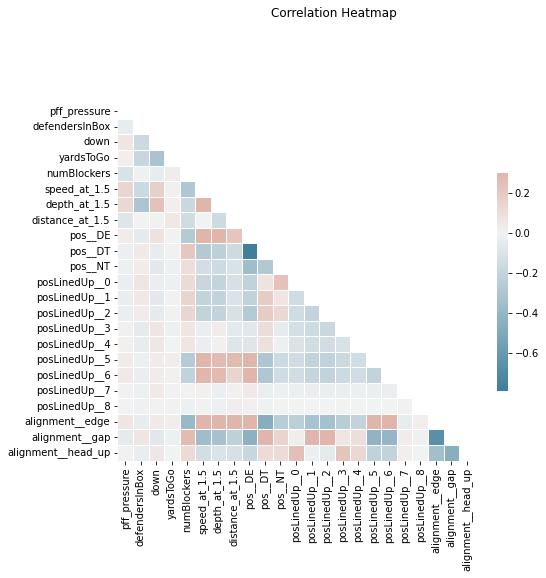

In [14]:
# Correlation matrix
corr = (model_c_df.corr(numeric_only=True))
mask = np.triu(np.ones_like(corr, dtype=bool))
figure = plt.figure(figsize=[8,8]).suptitle("Correlation Heatmap")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### **Modeling**

In [15]:
## Get the model data

# Model data w N/As dropped
model_c_df = model_c_df.dropna()

# Features
features = model_c_df.drop(columns=['pff_pressure'])

# Target
target = model_c_df['pff_pressure']

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, shuffle=True)

# Balance the sample of training data for the outcome class (with/without a pressure)
under_sampler = RandomUnderSampler(random_state=77)
x_train, y_train = under_sampler.fit_resample(x_train, y_train)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0.0: 1795, 1.0: 1795})
Testing target statistics: Counter({0.0: 4283, 1.0: 429})


Experiment Results:


,Model Name,Precision,Recall,F1,Accuracy
0,Decision Tree,0.108948,0.547786,0.181748,0.550934
1,kNN (k=5),0.117590,0.568765,0.194888,0.572156
2,kNN (k=7),0.127219,0.601399,0.210012,0.588073
3,kNN (k=9),0.134073,0.620047,0.220472,0.600806


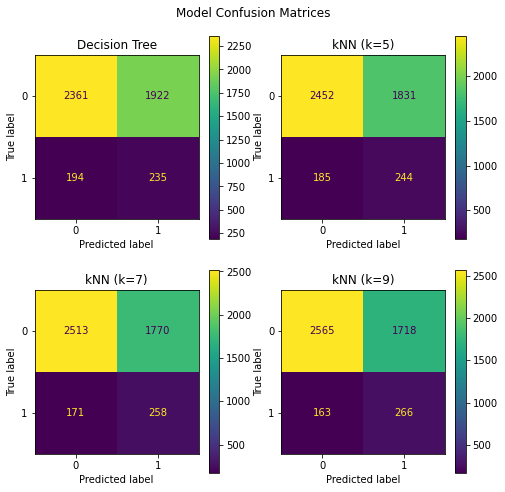

In [16]:
## Run the experiments
decision_tree_models = {"Decision Tree":tree.DecisionTreeClassifier()}
knn_models = {"kNN (k=5)":neighbors.KNeighborsClassifier(n_neighbors=5),
            "kNN (k=7)":neighbors.KNeighborsClassifier(n_neighbors=7),
            "kNN (k=9)":neighbors.KNeighborsClassifier(n_neighbors=9)}
models = decision_tree_models | knn_models

run_experiments(models, x_train, y_train, x_test, y_test)